# Coding 1 & Data Analysis 2 - Home Assignment 2
### Authors: Gréta Zsikla & Márton Nagy

Importing the needed packages.

In [1]:
import pandas as pd
import math
import numpy as np
from plotnine import *
import patchworklib as pw
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
from currency_converter import CurrencyConverter
from datetime import timedelta
import scipy.stats as stats
from IPython.display import display
from mizani.formatters import percent_format
import copy
import statsmodels.nonparametric.kernel_regression as loess

## Importing the raw data files

Reading the raw Excel-sheet, as downloaded from TEIR.

In [86]:
raw = pd.read_excel('https://github.com/marton-nagy-marton/DA2_assignment2/raw/refs/heads/main/source_data_teir_ksh.xlsx', sheet_name='raw')

Renaming the indicators to be computer friendly and transposing the DataFrame.

In [87]:
indicators_renamed = [
    "muni_name",
    "comm_work",
    "romani_pctg",
    "dependence_rate",
    "pop",
    "pop_15_64f",
    "pop_15_64m",
    "county_center_min",
    "hprest_emp_pctg",
    "unemp_pctg",
    "area",
    "roads_undev",
    "roads_dev",
    "roads_total",
    "income",
    "gp_visits",
    "elem_students",
    "disadv_elem_students",
    "crime_per1000people",
    "low_comf_housing",
    "educ_level_max_elem",
    "migration_per1000",
    "growth_decline_per1000",
    "elem_stud_from_other_muni_pctg",
    "pop_65-x_m",
    "pop_65-x_f",
    "people_in_agriculture",
    "employed",
    "pop_7_x"
]
tidy = raw.iloc[:,1:].T
tidy.reset_index(drop = False, inplace = True)
tidy.columns = indicators_renamed
tidy

,muni_name,comm_work,romani_pctg,dependence_rate,pop,pop_15_64f,pop_15_64m,county_center_min,hprest_emp_pctg,unemp_pctg,...,low_comf_housing,educ_level_max_elem,migration_per1000,growth_decline_per1000,elem_stud_from_other_muni_pctg,pop_65-x_m,pop_65-x_f,people_in_agriculture,employed,pop_7_x
0,Aba (1737),10.0,0.41,47.89,4633.0,1662.0,1797.0,20.48,12.25,51.81,...,5.89,1188.0,-3.82,-3.14,12.87,255.0,439.0,22.0,2366.0,4051.0
1,Abádszalók (1244),136.0,4.24,56.27,4180.0,1402.0,1570.0,61.78,15.33,44.59,...,10.96,982.0,5.17,-13.97,17.77,366.0,514.0,10.0,1688.0,3608.0
2,Abaliget (1254),13.0,8.57,57.18,659.0,234.0,251.0,22.75,26.47,37.50,...,6.34,99.0,-24.04,-1.60,47.19,44.0,59.0,1.0,323.0,572.0
3,Abasár * (2455),4.0,0.51,59.62,2540.0,817.0,938.0,44.45,19.81,49.43,...,5.27,442.0,28.49,-18.99,29.21,229.0,350.0,4.0,1270.0,2359.0
4,Abaújalpár (1566),5.0,NaN,39.13,67.0,28.0,26.0,46.28,20.00,100.00,...,NaN,21.0,0.00,0.00,NaN,3.0,8.0,0.0,30.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,Zsennye (1229),NaN,NaN,80.36,106.0,31.0,33.0,29.62,21.05,60.00,...,NaN,17.0,0.00,0.00,NaN,15.0,17.0,0.0,39.0,82.0
3151,Zsira (462),NaN,0.35,48.82,850.0,302.0,300.0,78.09,21.60,NaN,...,4.98,187.0,23.34,-25.80,50.78,72.0,96.0,0.0,412.0,819.0
3152,Zsombó (1776),4.0,0.15,50.25,3574.0,1259.0,1380.0,20.08,26.74,40.00,...,8.22,626.0,12.91,0.90,13.43,283.0,338.0,6.0,1778.0,3124.0
3153,Zsujta (1102),11.0,16.74,102.75,239.0,63.0,67.0,51.14,11.84,73.33,...,16.48,79.0,307.29,-46.88,NaN,22.0,64.0,1.0,79.0,204.0


Extracting the municipality ID and municipality name from the raw data.

In [90]:
tidy['muni_id'] = tidy['muni_name'].apply(lambda x: int(x.split('(')[-1].split(')')[0]))
tidy['muni_name'] = tidy['muni_name'].apply(lambda x: x.replace(' *', '').split(' (')[0])

We connect the data using the municipality names to an administrative dataset on the status, counties and districts of each municipality. This is the 'Helységnévtár' sheet downloaded from KSH.

In [92]:
status = pd.read_excel('https://github.com/marton-nagy-marton/DA2_assignment2/raw/refs/heads/main/source_data_teir_ksh.xlsx', sheet_name='hnt', skiprows = 2)
merged = tidy.merge(status, how = 'inner', left_on='muni_name', right_on='Helység megnevezése')
tidy['status'] = merged['Helység jogállása'].str.strip()
tidy['county'] = merged['Vármegye megnevezése'].str.strip()
tidy['district'] = merged['Járás neve'].str.strip()

## Data cleaning and dealing with missing values

Applying some cleaning to the status column: we create a dummy for the municipality being a county center.

In [94]:
tidy['status'].unique()

array(['város', 'község', 'nagyközség', 'megyei jogú város',
       'megyeszékhely, megyei jogú város', 'főváros'], dtype=object)

In [96]:
tidy['is_county_center'] = tidy['status'].apply(lambda x: 1 if x in ['megyeszékhely, megyei jogú város', 'főváros'] else 0)

In [98]:
tidy['status'] = tidy['status'].apply(lambda x: 'megyei jogú város' if x == 'megyeszékhely, megyei jogú város' else x)

Reordering the columns.

In [100]:
tidy = tidy.filter(['muni_id','muni_name','status','is_county_center','county','district','comm_work','romani_pctg','dependence_rate','pop','pop_15_64f','pop_15_64m',
              'county_center_min','hprest_emp_pctg','unemp_pctg','area','roads_undev','roads_dev','roads_total','income','gp_visits',
              'elem_students','disadv_elem_students','crime_per1000people','low_comf_housing','educ_level_max_elem',
              'migration_per1000','growth_decline_per1000','elem_stud_from_other_muni_pctg','pop_65-x_m','pop_65-x_f','people_in_agriculture',
              'employed', 'pop_7_x'])

Now let's inspect the DataFrame to see the number of missing values by variable.

In [102]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   muni_id                         3155 non-null   int64  
 1   muni_name                       3155 non-null   object 
 2   status                          3155 non-null   object 
 3   is_county_center                3155 non-null   int64  
 4   county                          3154 non-null   object 
 5   district                        3154 non-null   object 
 6   comm_work                       2914 non-null   float64
 7   romani_pctg                     2352 non-null   float64
 8   dependence_rate                 3155 non-null   float64
 9   pop                             3155 non-null   float64
 10  pop_15_64f                      3155 non-null   float64
 11  pop_15_64m                      3155 non-null   float64
 12  county_center_min               31

Now let's deal with missing values for each variable.

In [104]:
tidy[tidy['county'].isna()]

,muni_id,muni_name,status,is_county_center,county,district,comm_work,romani_pctg,dependence_rate,pop,...,low_comf_housing,educ_level_max_elem,migration_per1000,growth_decline_per1000,elem_stud_from_other_muni_pctg,pop_65-x_m,pop_65-x_f,people_in_agriculture,employed,pop_7_x
393,1357,Budapest,főváros,1,NaN,NaN,510.0,0.77,51.02,1630320.0,...,1.2,202503.0,-3.02,-4.69,9.16,136116.0,226702.0,1192.0,913266.0,1590653.0


It turns out that the capital does not have statistically a district and a county. For our purposes, let's change this by assigning Budapest as a county and a district.

In [106]:
tidy['county'] = tidy['county'].fillna('Budapest')
tidy['district'] = tidy['district'].fillna('Budapest')

For the quantitative variables, let's look at the descriptive statistics first.

In [108]:
desc_na = tidy.iloc[:,6:].describe().T
desc_na[desc_na['count'] != 3155]

,count,mean,std,min,25%,50%,75%,max
comm_work,2914.0,26.140014,48.085477,1.00,4.0000,10.000,26.7500,734.00
romani_pctg,2352.0,5.968274,9.497803,0.09,0.8000,2.440,6.9725,90.16
county_center_min,3136.0,44.438712,20.391054,6.80,29.3875,42.030,56.3025,144.94
hprest_emp_pctg,3152.0,15.747018,8.595697,0.43,10.0800,13.760,19.4800,73.91
unemp_pctg,3023.0,54.358951,16.616119,7.69,43.8000,54.050,63.6650,100.00
roads_undev,2889.0,5.372918,12.960453,0.01,1.0500,2.230,5.3100,304.58
roads_dev,3109.0,13.611039,88.040840,0.01,2.2000,4.890,11.3400,4643.50
roads_total,3141.0,18.414225,95.542847,0.05,3.6500,7.660,16.4200,4948.08
elem_students,1742.0,410.536739,2950.346566,5.00,88.0000,146.000,250.7500,117627.00
disadv_elem_students,1430.0,26.660839,45.338232,1.00,5.0000,14.000,33.0000,1034.00


As we can see, most of the variables have a larger than 0 minimum, which is suspicious. The reason for this is most apparent in the case of county_center_min: missing values should actually be zero!

In [110]:
tidy[tidy['county_center_min'].isna()][['muni_name', 'is_county_center']]

,muni_name,is_county_center
251,Békéscsaba,1
393,Budapest,1
556,Debrecen,1
660,Eger,1
919,Győr,1
1199,Kaposvár,1
1241,Kecskemét,1
1738,Miskolc,1
1966,Nyíregyháza,1
2127,Pécs,1


As we can see, the only missing values are for those municipalities that are county centers themselves.

We decided to impute missing values with zero for the every variable except: roads_total, roads_undev, roads_dev, students_from_other_village_pctg, and pop_7_x. We will get back to these variables later.

In [112]:
tidy[['comm_work', 'romani_pctg', 'dependence_rate', 'pop', 'pop_15_64f', 'pop_15_64m',
      'county_center_min', 'hprest_emp_pctg', 'unemp_pctg', 'area', 'income', 'gp_visits',
      'elem_students', 'disadv_elem_students', 'crime_per1000people', 
      'low_comf_housing', 'educ_level_max_elem', 'migration_per1000', 'growth_decline_per1000', 
      'pop_65-x_m', 'pop_65-x_f', 'people_in_agriculture', 'employed']] = \
tidy[['comm_work', 'romani_pctg', 'dependence_rate', 'pop', 'pop_15_64f', 'pop_15_64m',
      'county_center_min', 'hprest_emp_pctg', 'unemp_pctg', 'area', 'income', 'gp_visits',
      'elem_students', 'disadv_elem_students', 'crime_per1000people', 
      'low_comf_housing', 'educ_level_max_elem', 'migration_per1000', 'growth_decline_per1000', 
      'pop_65-x_m', 'pop_65-x_f', 'people_in_agriculture', 'employed']].fillna(0)


For the roads variables, it is not quite obvious what the missing values represent, even though the minima are never zero. E.g. for some municipalities the total is given but there is no breakdown whether the roads are developed or undeveloped. Also, these variables give information only about roads managed by the municipality government. So, we have decided not to include these variables in our analysis as it was ambigous how we should treat missing values (and there were a lot of missing values).

For the population above 7 years of age, it is unplausible that there is a municipality where there are no people above 7. However, as only one observation is missing, we can simply exclude that.

For the percentage of students from other municipalities, the minimum is already zero. This indicates that there are students in that municipality, but there are no students from other municipalities. So, this variable should only be missing if there are no students in that municipality, as then we would have to divide by zero. We can check if this is the case.

In [114]:
tidy.shape

(3155, 34)

In [116]:
tidy.drop(columns = ['roads_undev','roads_dev','roads_total'], inplace = True)
tidy = tidy[tidy['pop_7_x'].notna()]

In [118]:
tidy.shape

(3154, 31)

Below, we can see that indeed, the percentage of students from other municipalities is only missing if the number of elementary students is zero. So these missing values make sense - thus we shall leave them as is for now.

In [120]:
tidy[(tidy['elem_students'] != 0) & tidy['elem_stud_from_other_muni_pctg'].isna()][['muni_name', 'elem_students', 'elem_stud_from_other_muni_pctg']]

,muni_name,elem_students,elem_stud_from_other_muni_pctg


Now we can create some new variables. What we do is basically two things:
- convert percentages to ratio variables,
- and calculate ratio variables (e.g. per capita, per employed people) by dividing with a sensible reference group.

In [122]:
tidy['pop_15_64'] = tidy['pop_15_64m'] + tidy['pop_15_64f']
tidy['pop_65_x'] = tidy['pop_65-x_m'] + tidy['pop_65-x_f']
tidy['pop_density'] = tidy['pop'] / tidy['area']
tidy['old_age_dependency_ratio'] = tidy['pop_65_x'] / tidy['pop_15_64']
tidy['gen_dependency_ratio'] = tidy['dependence_rate'] / 100
tidy['comm_work_per_employed'] = tidy['comm_work'] / tidy['employed']
tidy['monthly_income_pc'] = tidy['income'] / tidy['pop'] / 12
tidy['max_elem_educ_ratio'] = tidy['educ_level_max_elem'] / tidy['pop_7_x']
tidy['agr_emp_ratio'] = tidy['people_in_agriculture'] / tidy['employed']
tidy['disadv_elem_students_ratio'] =  tidy['disadv_elem_students'] / tidy['elem_students']
tidy['avg_gp_visits_pc'] = tidy['gp_visits'] / tidy['pop']
tidy['romani_ratio'] = tidy['romani_pctg'] / 100
tidy['hprest_emp_ratio'] = tidy['hprest_emp_pctg'] / 100
tidy['unemp_ratio'] = tidy['unemp_pctg'] / 100
tidy['elem_stud_from_other_muni_ratio'] = tidy['elem_stud_from_other_muni_pctg'] / 100
tidy['low_comf_housing_ratio'] = tidy['low_comf_housing'] / 100

In [124]:
tidy = tidy.filter([
    'muni_id',
    'muni_name',
    'status',
    'is_county_center',
    'county',
    'district',
    'comm_work_per_employed',
    'romani_ratio',
    'monthly_income_pc',
    'unemp_ratio',
    'hprest_emp_ratio',
    'agr_emp_ratio',
    'pop_density',
    'old_age_dependency_ratio',
    'gen_dependency_ratio',
    'migration_per1000',
    'growth_decline_per1000',
    'max_elem_educ_ratio',
    'disadv_elem_students_ratio',
    'elem_stud_from_other_muni_ratio',
    'county_center_min',
    'low_comf_housing_ratio',
    'crime_per1000people',
    'avg_gp_visits_pc',
    'pop',
    'area'
])

In [126]:
tidy.iloc[:,5:].describe().T

,count,mean,std,min,25%,50%,75%,max
comm_work_per_employed,3154.0,0.060158,0.090473,0.000000,0.006509,0.025499,0.077306,9.723757e-01
romani_ratio,3154.0,0.044507,0.086034,0.000000,0.000000,0.011650,0.046900,9.016000e-01
monthly_income_pc,3154.0,144094.057371,44823.142441,20377.844887,112652.492078,141648.685080,172594.374752,4.901384e+05
unemp_ratio,3154.0,0.521012,0.195523,0.000000,0.421100,0.529400,0.633300,1.000000e+00
hprest_emp_ratio,3154.0,0.157226,0.085904,0.000000,0.100725,0.137600,0.194375,7.391000e-01
agr_emp_ratio,3154.0,0.011689,0.017606,0.000000,0.001330,0.005797,0.014794,1.764706e-01
pop_density,3154.0,73.549782,133.183612,1.515152,25.833222,42.381289,72.074074,3.104603e+03
old_age_dependency_ratio,3154.0,0.273532,0.089486,0.034063,0.220081,0.261092,0.313575,1.085106e+00
gen_dependency_ratio,3154.0,0.547398,0.093281,0.115400,0.494600,0.539850,0.590675,1.750000e+00
migration_per1000,3154.0,0.305371,33.919665,-514.290000,-13.352500,0.285000,15.087500,3.072900e+02


There is one thing left to do for dealing with missing values. We shall set the student ratio variables to 0 if they are missing (remember, this indicated that there are no elementary students in that municipality), but we should also create a dummy flag to capture this.

In [128]:
tidy['no_elem_stud'] = tidy['disadv_elem_students_ratio'].apply(lambda x: 1 if pd.isna(x) else 0)

In [130]:
tidy[['disadv_elem_students_ratio', 'elem_stud_from_other_muni_ratio']] = tidy[['disadv_elem_students_ratio', 'elem_stud_from_other_muni_ratio']].fillna(0)

We have decided to exclude Budapest, the capital of Hungary of the analysis, as we do not have district-level data on it, without which analysing it is kind of meaningless.

In [132]:
tidy = tidy[tidy['muni_name'] != 'Budapest']

## Exploratory data analysis

In [134]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3153 entries, 0 to 3154
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   muni_id                          3153 non-null   int64  
 1   muni_name                        3153 non-null   object 
 2   status                           3153 non-null   object 
 3   is_county_center                 3153 non-null   int64  
 4   county                           3153 non-null   object 
 5   district                         3153 non-null   object 
 6   comm_work_per_employed           3153 non-null   float64
 7   romani_ratio                     3153 non-null   float64
 8   monthly_income_pc                3153 non-null   float64
 9   unemp_ratio                      3153 non-null   float64
 10  hprest_emp_ratio                 3153 non-null   float64
 11  agr_emp_ratio                    3153 non-null   float64
 12  pop_density              

In [136]:
tidy.iloc[:,5:].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.4f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
comm_work_per_employed,3153.0000,0.0602,0.0905,0.0000,0.0000,0.0065,0.0255,0.0773,0.2343,0.9724
romani_ratio,3153.0000,0.0445,0.0860,0.0000,0.0000,0.0000,0.0117,0.0469,0.2103,0.9016
monthly_income_pc,3153.0000,144059.0265,44787.0495,20377.8449,75687.0282,112648.1990,141647.3822,172535.5437,221016.7282,490138.4280
unemp_ratio,3153.0000,0.5210,0.1956,0.0000,0.1667,0.4211,0.5294,0.6333,0.8107,1.0000
hprest_emp_ratio,3153.0000,0.1571,0.0858,0.0000,0.0544,0.1007,0.1376,0.1943,0.3239,0.7391
agr_emp_ratio,3153.0000,0.0117,0.0176,0.0000,0.0000,0.0013,0.0058,0.0148,0.0436,0.1765
pop_density,3153.0000,72.5885,121.7696,1.5152,11.5497,25.8322,42.3745,72.0000,218.3228,2094.4079
old_age_dependency_ratio,3153.0000,0.2735,0.0895,0.0341,0.1563,0.2200,0.2611,0.3135,0.4314,1.0851
gen_dependency_ratio,3153.0000,0.5474,0.0933,0.1154,0.4192,0.4946,0.5399,0.5907,0.6962,1.7500
migration_per1000,3153.0000,0.3064,33.9250,-514.2900,-48.1060,-13.3600,0.3100,15.0900,46.3200,307.2900


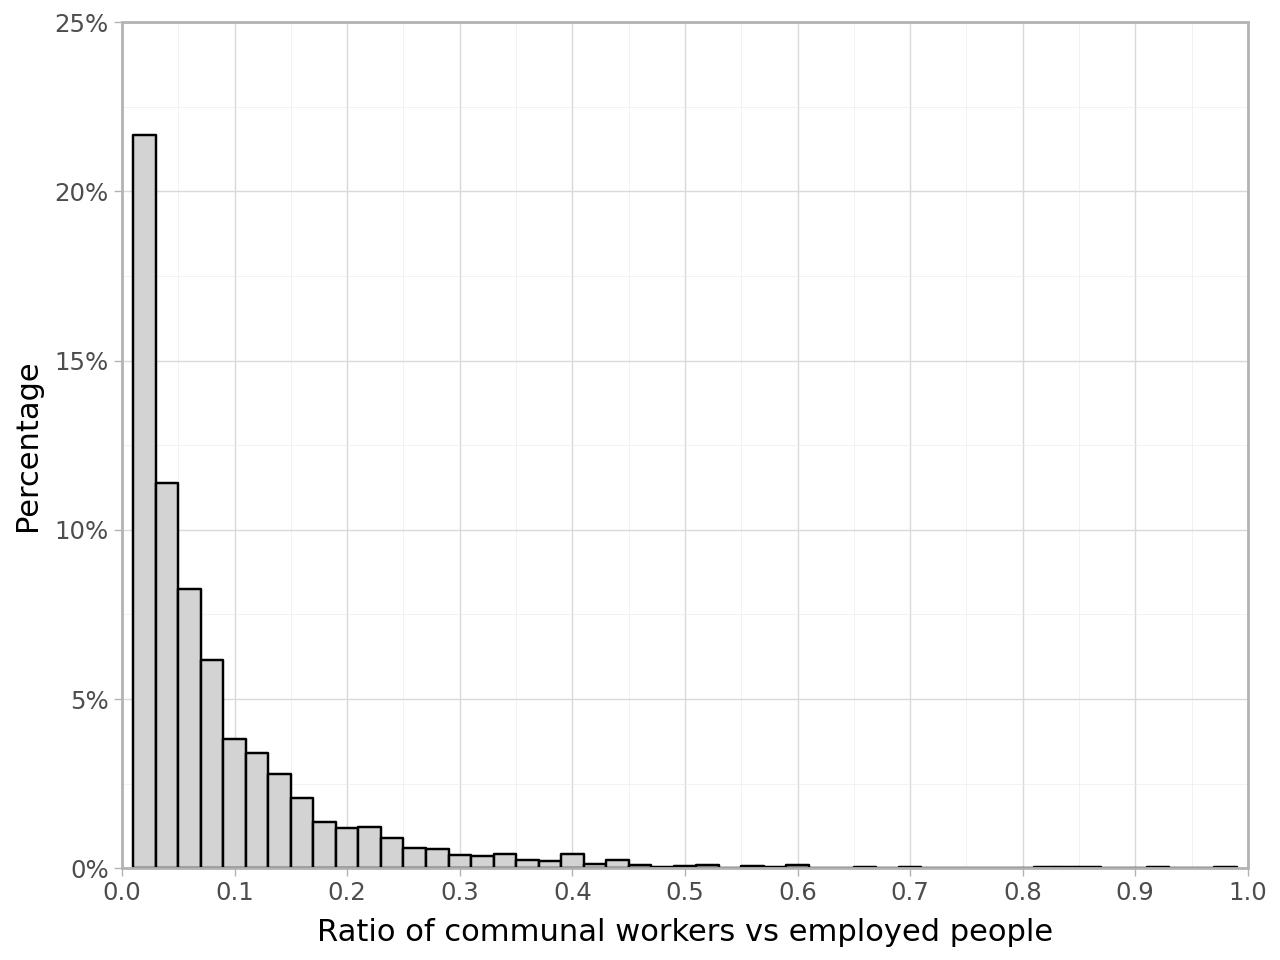

In [187]:
(
    ggplot(tidy)
    + aes(x = 'comm_work_per_employed')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.02
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 1),
        breaks= np.arange(0, 1.1,0.1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.25),
        breaks=np.arange(0,0.30,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'Ratio of communal workers vs employed people',
        y = 'Percentage'
    )
    + theme_light()
)

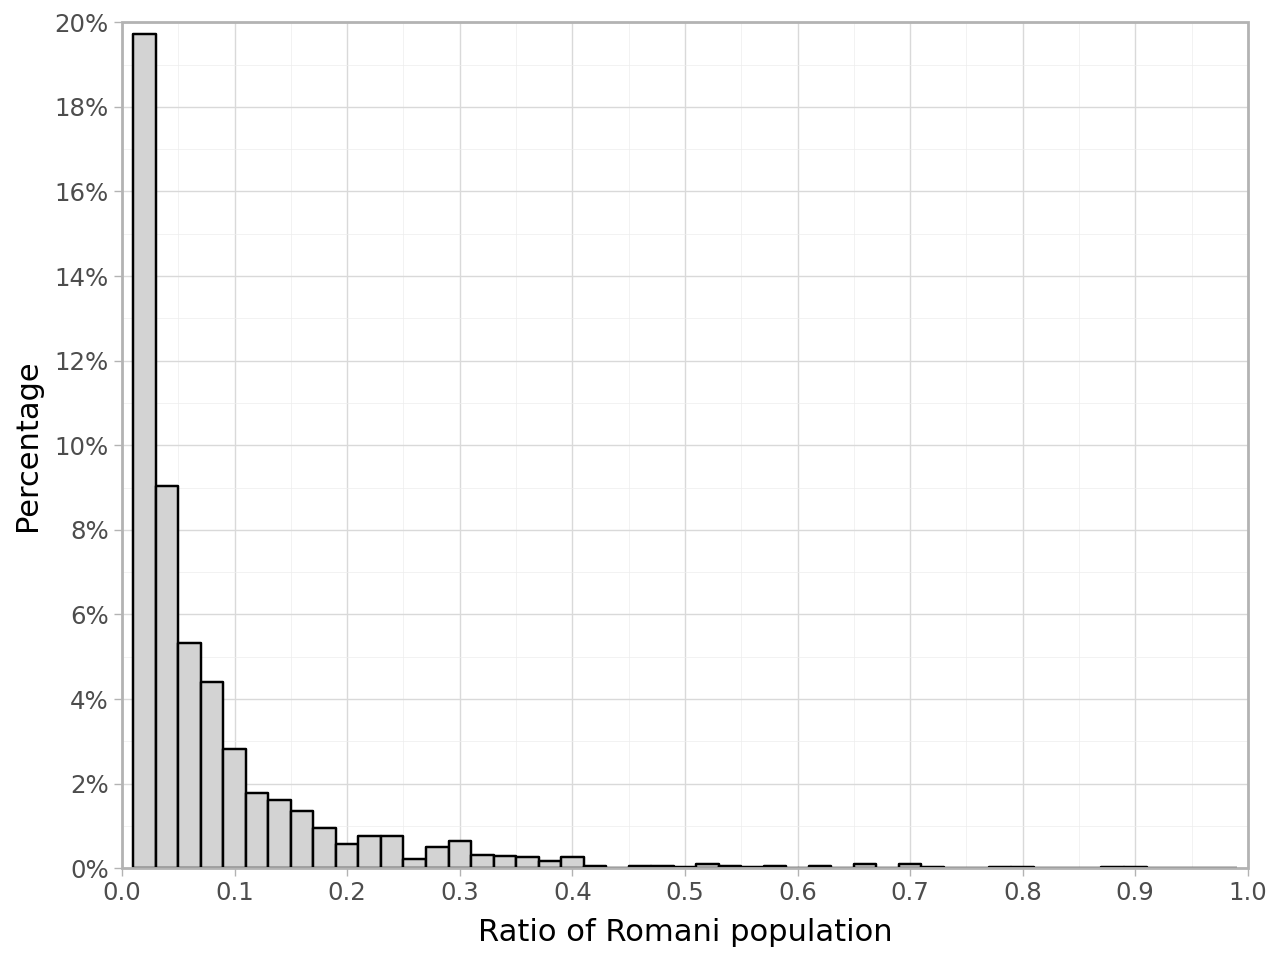

In [268]:
(
    ggplot(tidy)
    + aes(x = 'romani_ratio')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.02
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 1),
        breaks= np.arange(0, 1.1,0.1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.2),
        breaks=np.arange(0,0.22,0.02),
        labels=percent_format()
    )
    + labs(
        x = 'Ratio of Romani population',
        y = 'Percentage'
    )
    + theme_light()
)

From the above histograms, it seems that both of our variables of interest have a very long right tail. However, there are also a significant amount of zero values as well. So, how should we handle this? We cannot simply drop all observations where either of the variables is zero, as we would end up with only 886 observations instead of 3153.

Our idea was the following:
- estimate two regression models: a probability model for the whole sample, where we predict the probability of the municipality having communal workers, and a regular OLS model for a subsample for municipalities where there are communal workers (here we can take the log as well);
- and we take the log of the Romani population by: (1) assigning a small, but positive value before taking the log, and (2) creating a flag to indicate whether the initial value was actually zero.

In [288]:
tidy['ln_romani_ratio'] = tidy['romani_ratio'].apply(
    lambda x: np.log(np.min(tidy[tidy['romani_ratio'] != 0].romani_ratio)*0.5)
    if x == 0
    else np.log(x))
tidy['romani_zero_flag'] = tidy['romani_ratio'].apply(lambda x: 1 if x == 0 else 0)
#note that this creates missing values, but that's fine, as we will only use this if it is not mising
tidy['ln_comm_work_per_employed'] =  tidy['comm_work_per_employed'].apply(lambda x: np.log(x) if x != 0 else np.nan)
tidy['has_comm_worker'] = tidy['comm_work_per_employed'].apply(lambda x: 1 if x != 0 else 0)

As we can see, the distribution of log(romani ratio) is better, but still not optimal - but this is the best we can do if we want our coefficients to remain interpretable.

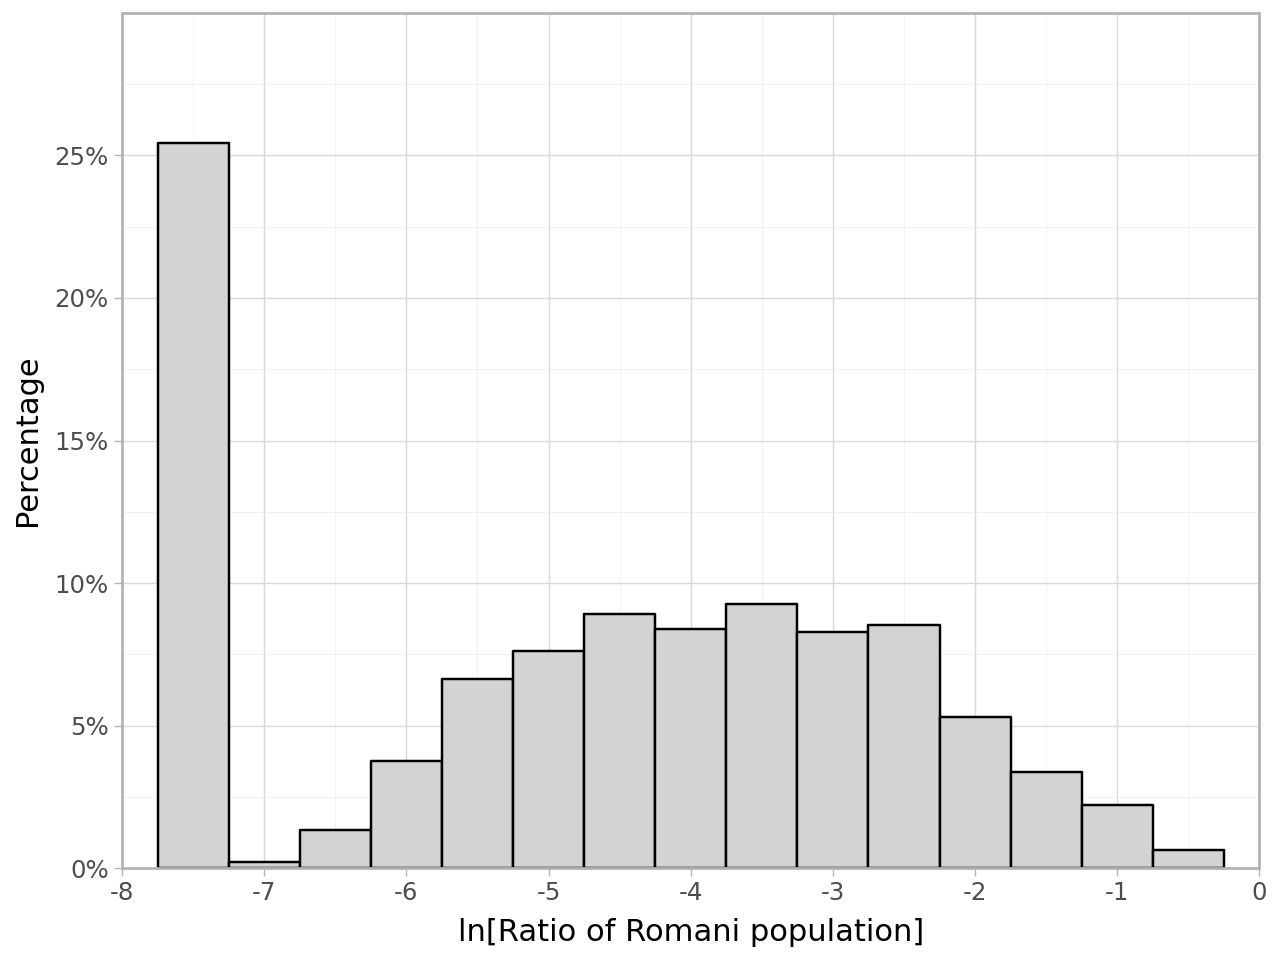

In [275]:
(
    ggplot(tidy)
    + aes(x = 'ln_romani_ratio')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-8, 0),
        breaks= np.arange(-8, 1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.3),
        breaks=np.arange(0,0.35,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Ratio of Romani population]',
        y = 'Percentage'
    )
    + theme_light()
)

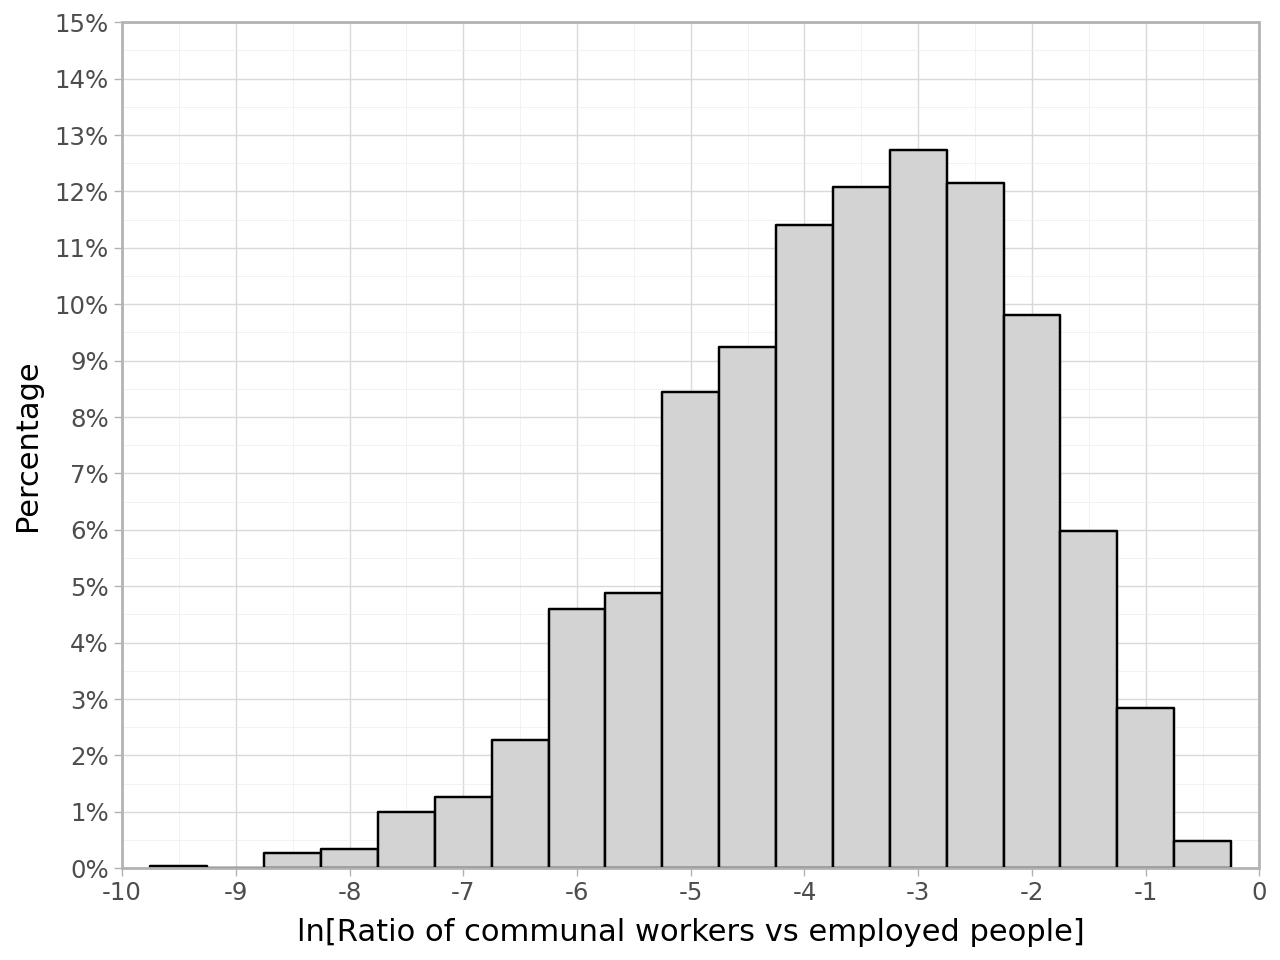

In [296]:
(
    ggplot(tidy)
    + aes(x = 'ln_comm_work_per_employed')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-10, 0),
        breaks= np.arange(-10, 1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Ratio of communal workers vs employed people]',
        y = 'Percentage'
    )
    + theme_light()
)

We can also take the log of all other variables that are strictly positive, as the summary statistics showed that these are also somewhat skewed. However, we leave all other variables unchanged, as we only want to include them as controls, so it does not really matter if their coefficients are somewhat unprecise.

In [302]:
tidy['ln_monthly_income_pc'] = np.log(tidy['monthly_income_pc'])
tidy['ln_pop_density'] = np.log(tidy['pop_density'])
tidy['ln_old_age_dependency_ratio'] = np.log(tidy['old_age_dependency_ratio'])
tidy['ln_gen_dependency_ratio'] = np.log(tidy['gen_dependency_ratio'])
tidy['ln_avg_gp_visits_pc'] = np.log(tidy['avg_gp_visits_pc'])
tidy['ln_pop'] = np.log(tidy['pop'])
tidy['ln_area'] = np.log(tidy['area'])

Finally, let's take a look at the summar statistics.

In [343]:
tidy.iloc[:,5:].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.4f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
comm_work_per_employed,3153.0000,0.0602,0.0905,0.0000,0.0000,0.0065,0.0255,0.0773,0.2343,0.9724
romani_ratio,3153.0000,0.0445,0.0860,0.0000,0.0000,0.0000,0.0117,0.0469,0.2103,0.9016
monthly_income_pc,3153.0000,144059.0265,44787.0495,20377.8449,75687.0282,112648.1990,141647.3822,172535.5437,221016.7282,490138.4280
unemp_ratio,3153.0000,0.5210,0.1956,0.0000,0.1667,0.4211,0.5294,0.6333,0.8107,1.0000
hprest_emp_ratio,3153.0000,0.1571,0.0858,0.0000,0.0544,0.1007,0.1376,0.1943,0.3239,0.7391
agr_emp_ratio,3153.0000,0.0117,0.0176,0.0000,0.0000,0.0013,0.0058,0.0148,0.0436,0.1765
pop_density,3153.0000,72.5885,121.7696,1.5152,11.5497,25.8322,42.3745,72.0000,218.3228,2094.4079
old_age_dependency_ratio,3153.0000,0.2735,0.0895,0.0341,0.1563,0.2200,0.2611,0.3135,0.4314,1.0851
gen_dependency_ratio,3153.0000,0.5474,0.0933,0.1154,0.4192,0.4946,0.5399,0.5907,0.6962,1.7500
migration_per1000,3153.0000,0.3064,33.9250,-514.2900,-48.1060,-13.3600,0.3100,15.0900,46.3200,307.2900


## Non-parametric regression analysis

For the binary-outcome set up, we can see a linear relationship until ln_romani_ratio = 4.5. After that, the loess curve shows practically no relationship.

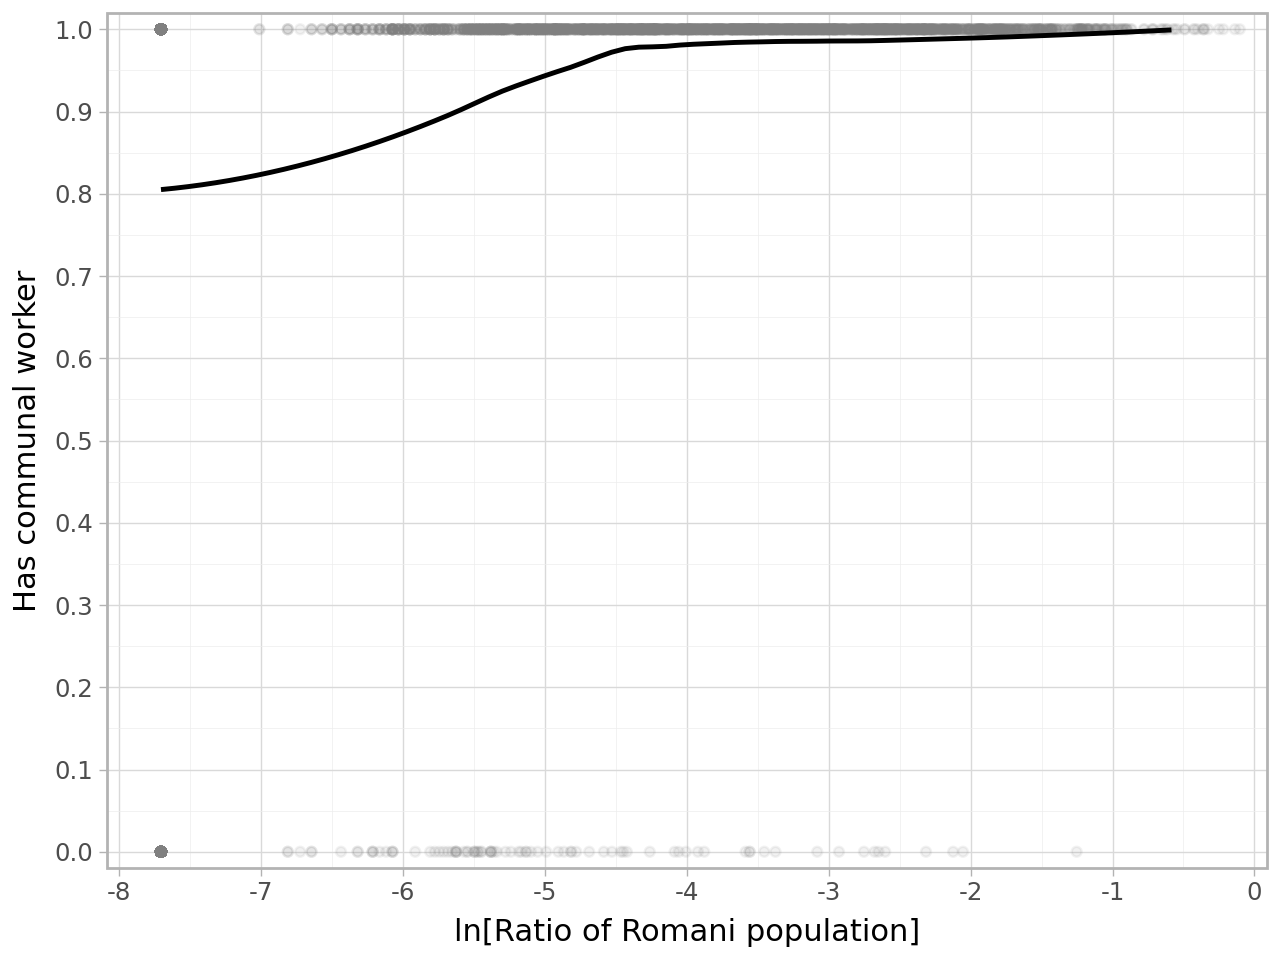

In [329]:
(
    ggplot(tidy)
    + aes(x = 'ln_romani_ratio', y = 'has_comm_worker')
    + geom_point(color = 'grey', alpha = 0.1)
    + geom_smooth(method = 'loess', se = False, span = 0.5)
    + theme_light()
    + scale_x_continuous(expand=(0.01, 0.01),
                         limits=(-8, 0),
                         breaks=np.arange(-8,1,1)
                        )
    + scale_y_continuous(expand=(0.01, 0.01),
                         limits = (0,1),
                         breaks=np.arange(0,1.1,0.1)
                        )
    + labs(x = 'ln[Ratio of Romani population]', y = 'Has communal worker')
)

For the regular set-up (with municipalities with no communal workers omitted), we can see a linear relationship if ln_romani_ratio is larger than -6. All in all, the relationship seems rather quadratic.

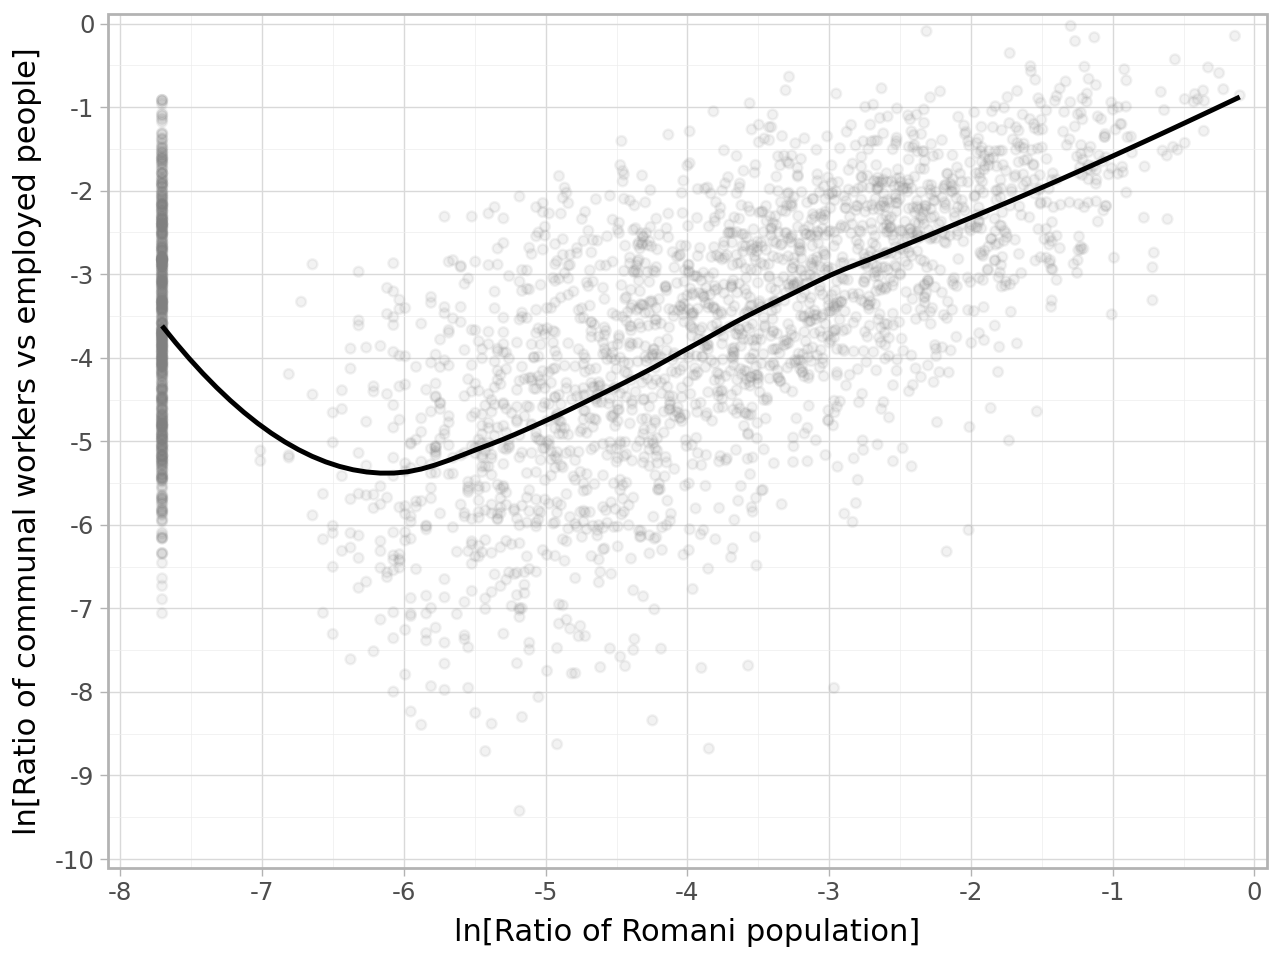

In [347]:
(
    ggplot(tidy[tidy['has_comm_worker'] == 1])
    + aes(x = 'ln_romani_ratio', y = 'ln_comm_work_per_employed')
    + geom_point(color = 'grey', alpha = 0.1)
    + geom_smooth(method = 'loess', se = False, span = 0.5)
    + theme_light()
    + scale_x_continuous(expand=(0.01, 0.01),
                         limits=(-8, 0),
                         breaks=np.arange(-8,1,1)
                        )
    + scale_y_continuous(expand=(0.01, 0.01),
                         limits = (-10,0),
                         breaks=np.arange(-10,1,1)
                        )
    + labs(x = 'ln[Ratio of Romani population]', y = 'ln[Ratio of communal workers vs employed people]')
)